### Florian Muthreich   ---   INF368   ---

# Ex1: ZooScanNet

## Setup

I chose to work with the default set of 40 classes from the ZooScanNet.
Since the images are variable in size and abundance in the different classes, i chose a couple of augmentations before fitting the model.

1. the images are cropped or padded to the desired size of 299 x 299. 
for images larger than 299 x 299. a sub image of 299 x 299 is randomly cropped out of the original image. for images smaller than 299 the respective dimensions are padded with empty pixels (white). 
2. I chose to over and undersample each category to 1000 images each.
3. The images are batch normalized.

### Architecture

I am using the Inception V3 with ImageNet weights. First I train a model with a top dense layer of 1000 neurons with relu activation before softmax, while the rest of Inception is frozen.
The first model has 13.254.056 trainable parameters of 23,941,960

In a second training run I unfreeze 2 Inception blocks at the top. 

### Results

I only managed to train for 5 epochs with each model. I simply ran out of time. The results can be seen below. some classes are quite precise and accurate, while a few others where over predicted across the board (i.e. annelida, egg_other).
the final train and validation accuracy were 91% train and 14% validation.

Task B: 
The classifier overwhelmingly produced low confidence predictions that seemed to focus on a couple of classes like i.e. annelida, egg_other (see figures), which is mainly due to insufficient training and regularization. 

### Improvements

i did not manage to train the full inception network, like i wanted to. Most of the time i spent figuring out the data generator and data augmentation. 

Code at: https://github.com/FM-uib/INF368

Instance I used: instance-gpu-fmuth

In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Dealing with class imbalance:
- resampling techniques
    - under or over sampling random vs informed
    - SMOTE synthetic minor ...
- kappa statistics/ MCC Metric
- multiclass mcc "comparing two k-category assignments by a k-category correlation coeeficient"


spatial pyramid pooling in deep convolutional networks for visual recognition

In [1]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from pathlib import Path
import keras
import random
from keras.utils import Sequence
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage.util import pad
from skimage.util import crop
import numpy as np
import math

Using TensorFlow backend.


In [2]:
class MY_Gen(Sequence):

    def __init__(self, image_filenames, labels, batch_size, shuffle, train):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.num_labels = len(np.unique(labels))
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train = True

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))
    
    def crop_or_pad(self, image, dim, filename):
        x, y, _ = image.shape
        if (y < dim and x < dim):
            image = pad(image, ((math.ceil((dim - x)/2),math.floor((dim - x)/2)),
                                (math.ceil((dim - y)/2),math.floor((dim - y)/2)), 
                                (0,0)), 'constant', constant_values = 255)
        elif (y >= dim and x >= dim):
            if x == 299:
                rand1 = 0
            else:
                rand1 = random.randint(1,x-dim)
            if y == 299:
                rand2=0
            else:
                rand2 = random.randint(1,y-dim)
            image = crop(image, ((rand1,x-dim-rand1),(rand2,y-dim-rand2),(0,0)))
        elif (x >= dim and y < dim):
            image = pad(image, ((0,0),
                                (math.ceil((dim - y)/2),math.floor((dim - y)/2)), 
                                (0,0)), 'constant', constant_values = 255)
            if x != 299:
                rand1 = random.randint(1,x-dim)
                image = crop(image, ((rand1,x-dim-rand1),
                                (0,0), (0,0)))
        else:
            #if y < dim: print(filename)
            image = pad(image, ((math.ceil((dim - x)/2),math.floor((dim - x)/2)),
                                (0,0), 
                                (0,0)), 'constant', constant_values = 255)
            if y != 299:
                rand2 = random.randint(1,y-dim)
                image = crop(image, ((0,0),
                                     (rand2,y-dim-rand2), (0,0)))
        return image
    
    def read_im(self, filename, dim):
        image = imread(filename)
        #image = resize(image, (dim,dim), anti_aliasing = True, mode = "reflect")
        image = skimage.color.gray2rgb(image)
        image = self.crop_or_pad(image, dim, filename)
        return image


    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        image = [self.read_im(filename, 299) for filename in batch_x]
        image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
        if self.train:    
            batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
            return np.array(image), np.array(batch_y)
        else:
            return np.array(image)
        #batch_y = keras.utils.to_categorical(batch_y, self.num_labels)

    
    def on_epoch_end(self):
        if self.shuffle == True:
            fnames_and_labels = list(zip(self.image_filenames, self.labels))
            random.shuffle(fnames_and_labels)
            self.image_filenames, self.labels = zip(*fnames_and_labels)

In [3]:
def fetch_data_set(path, ftype = 'jpg'):
    p = Path(path)
    files = list(p.glob('**/*.'+ftype))
    classes = str(files).split('/')
    classes = [classes[i] for i in list(range(2,len(classes),3)) ]
    classnames, indices = np.unique(classes, return_inverse=True)
    dict_classes = dict(zip(classnames, list(range(0,len(classes)))))
    return files, classes, dict_classes


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from itertools import chain

def over_under_sample(files, classes, dict_classes, num_to_undersample = 15000, num_to_oversample = 7500):
    files_array = np.array(files).reshape(-1,1)
    dic = {}
    for i in list(classes):
        dic[i] = dic.get(i,0) + 1

    classes_to_oversample = dict((k, v) for k, v in dic.items() if v < num_to_oversample)
    classes_to_undersample = dict((k, v) for k, v in dic.items() if v > num_to_undersample)    
    
    for key, value in classes_to_undersample.items():
        classes_to_undersample[key] = num_to_undersample
    for key, value in classes_to_oversample.items():
        classes_to_oversample[key] = num_to_oversample
    
    ros = RandomOverSampler(sampling_strategy = classes_to_oversample)
    rus = RandomUnderSampler(sampling_strategy = classes_to_undersample)
    x_over, y_over = ros.fit_resample(files_array, classes)
    x_under, y_under = rus.fit_resample(x_over, y_over)
    x_under = list(chain(*x_under.tolist()))
    return x_under, y_under
    
from sklearn.model_selection import train_test_split

def split_data_train_validation_test(data_X, data_Y, test_percent, validation_percent, seed): 
    assert (test_percent < 1) and (0 < validation_percent) and (validation_percent < 1)
    X_tmp, X_val, Y_tmp, Y_val = train_test_split(data_X, data_Y, test_size=validation_percent, shuffle=True, random_state=seed)
    
    if test_percent != 0:
        relative_test_percent = test_percent / (1 - validation_percent)
        X_train, X_test, Y_train, Y_test = train_test_split(X_tmp, Y_tmp, test_size=relative_test_percent, shuffle=True, random_state=seed)
        split_data = [X_train, Y_train, X_val, Y_val, X_test, Y_test]
    else:
        X_train, Y_train = X_tmp, Y_tmp
        split_data = [X_train, Y_train, X_val, Y_val]

    return split_data  

def encode_labels(labels, OneHot=True, encoder = None):
    if OneHot and encoder == None:
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder()
        enc.fit(np.array(labels).reshape(-1, 1))
        OneHot = enc.transform(np.array(labels).reshape(-1, 1)).toarray()
        return OneHot, enc
    else:
        OneHot = encoder.transform(np.array(labels).reshape(-1, 1)).toarray()
        return OneHot
    # mlb 
    #1 convert labels to multilabel using hardcoded dict
    #2 fit mlb
    #3 transform 
    # return labels and encoder
    # repeat for when encoder is present

In [4]:
# read dataset
files, classes, dict_classes = fetch_data_set("./data/imgs/")
# split dataset
split = split_data_train_validation_test(files, classes, 0.05, .1, random.randint(1,10000))
split[0], split[1] = over_under_sample(split[0], split[1], dict_classes, num_to_undersample = 1000, num_to_oversample = 1000)
# load label encoder and transform labels
split[1], OH_enc = encode_labels(split[1], OneHot = True)
split[3] = encode_labels(split[3], encoder = OH_enc)

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import keras_metrics
from keras import backend as K

base_model = InceptionV3(weights='imagenet', include_top=False)


x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(40, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [8]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

def step_decay_schedule(base_lr=1e-4, decay_factor=0.5, step_decay=5):
    def schedule(epoch):
        ## Multiply learning rate by 'decay_factor' every 'step_size' epochs (note that epoch is indexed from 0):
        updated_lr = base_lr * (decay_factor ** np.floor((epoch + 1) / step_decay))  
        return updated_lr    
    return LearningRateScheduler(schedule)

batch_size = 30
training_batch = MY_Gen(split[0], split[1], batch_size, shuffle = True, train = True)
validation_batch = MY_Gen(split[2], split[3], batch_size, shuffle = True, train = True)
test_batch = MY_Gen(split[4], split[5], batch_size, shuffle = False, train = False)

lr_policy = step_decay_schedule()
callback_list = [lr_policy]
callback_list.append(EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=0,
                                   mode='min',
                                   baseline=None,
                                   restore_best_weights=False))
callback_list.append(ModelCheckpoint("./checkpoints/model_{epoch:02d}.hdf5", 
                                              monitor='val_loss', 
                                              verbose=0, 
                                              save_best_only=True, save_weights_only=False))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=[keras_metrics.precision(), keras_metrics.recall(),'accuracy'])

history = model.fit_generator(generator=training_batch,
                    validation_data = validation_batch,
                    validation_steps = (len(split[2]) // batch_size),
                    steps_per_epoch=(len(split[0]) // batch_size),
                    epochs=5,
                    verbose=1,
                    callbacks = callback_list,
                    use_multiprocessing=True,
                    workers=16,
                    max_queue_size=32)

Epoch 1/5
1333/1333 [==============================] - 876s 657ms/step - loss: 1.3556 - precision: 0.8373 - recall: 0.4174 - acc: 0.5922 - val_loss: 3.9244 - val_precision: 0.0830 - val_recall: 0.3568 - val_acc: 0.1275
Epoch 2/5
1333/1333 [==============================] - 892s 670ms/step - loss: 1.2889 - precision: 0.8300 - recall: 0.4595 - acc: 0.6124 - val_loss: 3.8247 - val_precision: 0.0877 - val_recall: 0.3260 - val_acc: 0.1454
Epoch 3/5
1333/1333 [==============================] - 893s 670ms/step - loss: 1.2440 - precision: 0.8158 - recall: 0.4731 - acc: 0.6197 - val_loss: 4.0589 - val_precision: 0.1102 - val_recall: 0.3436 - val_acc: 0.1314
Epoch 4/5
1333/1333 [==============================] - 894s 671ms/step - loss: 1.2072 - precision: 0.8197 - recall: 0.4825 - acc: 0.6333 - val_loss: 4.1791 - val_precision: 0.1032 - val_recall: 0.3540 - val_acc: 0.1214
Epoch 5/5
1333/1333 [==============================] - 855s 641ms/step - loss: 1.1372 - precision: 0.8560 - recall: 0.5186 -

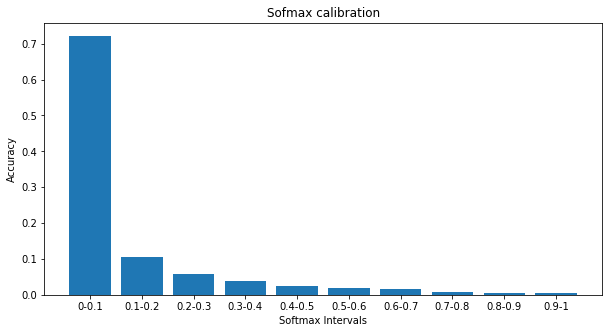

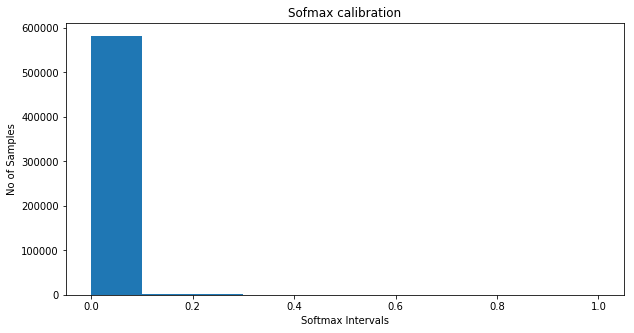

Predicted,Annelida,Bivalvia__Mollusca,Brachyura,Cavoliniidae,Centropagidae,Corycaeidae,Coscinodiscus,Decapoda,Doliolida,Eucalanidae,...,eudoxie__Diphyidae,gonophore__Diphyidae,multiple__Copepoda,multiple__other,nauplii__Cirripedia,nauplii__Crustacea,tail__Appendicularia,tail__Chaetognatha,zoea__Decapoda,All
Actual,,,,,,,,,,,,,,,,,,,,,
Annelida,64,0,0,0,0,5,0,2,0,0,...,0,0,1,0,0,7,0,0,0,125
Bivalvia__Mollusca,0,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,221
Brachyura,5,0,45,0,7,13,0,1,0,0,...,2,0,1,0,10,19,0,0,4,262
Candaciidae,7,0,0,0,2,10,0,0,0,0,...,0,0,1,0,0,8,0,0,0,119
Cavoliniidae,4,0,1,66,0,4,0,0,0,0,...,2,0,0,0,2,0,0,0,0,114
Centropagidae,0,0,0,0,20,10,0,0,0,0,...,0,0,0,0,0,2,0,0,0,249
Corycaeidae,7,0,1,0,0,127,0,0,0,0,...,0,0,0,0,4,9,0,0,0,517
Coscinodiscus,0,69,0,5,0,0,8,0,0,0,...,10,0,0,0,0,67,0,0,0,688
Decapoda,68,0,0,0,0,8,0,26,0,0,...,3,0,1,0,1,10,3,3,3,200


In [40]:
def plot_cm_calib(model, data, labels, OH_enc, dict_classes, batch_size = 100):
    import pandas as pd
    #split[5] = encode_labels(split[5], OneHot=True, encoder = OH_enc)
    test_batch = MY_Gen(data, labels, batch_size = batch_size, shuffle = False, train = False)
    model_pred = model.predict_generator(generator = test_batch, steps = (len(data) // batch_size))
    t = {v: k for k, v in dict_classes.items()}
#test_actu = OH_enc.inverse_transform(split[5]).flatten()
    test_pred = [t[i] for i in np.argmax(model_pred, axis = 1, out = None)]
    cm = pd.crosstab(np.array(labels), np.array(test_pred), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    bins = np.arange(0,1.1,0.1)
    acc = np.zeros([10,1])
    pred = model_pred
    actu = np.array(test_pred) == np.array(labels)
    actu = actu.reshape([len(data),1])
    for i in range(len(bins)-1):
        pred = pred*(OH_enc.transform(np.array(labels).reshape(-1,1)).toarray() == 1)
        tmp = ((pred > bins[i]) & (pred < bins[i+1]))
        if sum(tmp.flatten()) == 0:
            acc[i] = 0
        else:
            acc[i] = np.sum(tmp)/np.sum(pred > 0)
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(0,10,1), height = acc.flatten())
    plt.xticks(np.arange(0,10,1), ['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4','0.4-0.5','0.5-0.6','0.6-0.7','0.7-0.8','0.8-0.9','0.9-1'])
    plt.xlabel("Softmax Intervals")
    plt.ylabel("Accuracy")
    plt.title("Sofmax calibration")
    plt.show()
    plt.figure(figsize=(10,5))
    plt.hist(pred.flatten(), range = (0,1))
    plt.xlabel("Softmax Intervals")
    plt.ylabel("No of Samples")
    plt.title("Sofmax calibration")
    plt.show()    
    return cm
plot_cm_calib(model, split[4], split[5], OH_enc, dict_classes, batch_size = 8)

Your classifier probably misclassifies some images. Investigate how well the accuracy of the
classifications match the softmax output values, for instance as a histogram with softmax
intervals (buckets) on the x-axis (e.g. 0.70-0.75), and the percentage correct classifications for
each bucket (e.g. 68%) on the y-axis. Is your classifier overconfident or underconfident, or
neutral?

In [41]:

model2 = model
for layer in model2.layers[:249]:
   layer.trainable = False
for layer in model2.layers[249:]:
   layer.trainable = True

lr_policy = step_decay_schedule()
callback_list = [lr_policy]
callback_list.append(EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=0,
                                   mode='min',
                                   baseline=None,
                                   restore_best_weights=False))
callback_list.append(ModelCheckpoint("./checkpoints/model2_{epoch:02d}.hdf5", 
                                              monitor='val_loss', 
                                              verbose=0, 
                                              save_best_only=True, save_weights_only=False))
model2.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=[keras_metrics.precision(), keras_metrics.recall(),'accuracy'])

history = model2.fit_generator(generator=training_batch,
                    validation_data = validation_batch,
                    validation_steps = (len(split[2]) // batch_size),
                    steps_per_epoch=(len(split[0]) // batch_size),
                    epochs=5,
                    verbose=1,
                    callbacks = callback_list,
                    use_multiprocessing=True,
                    workers=16,
                    max_queue_size=32)

Epoch 1/5
1333/1333 [==============================] - 859s 644ms/step - loss: 1.0262 - precision: 0.8357 - recall: 0.5950 - acc: 0.6809 - val_loss: 3.9168 - val_precision: 0.0764 - val_recall: 0.7269 - val_acc: 0.1551
Epoch 2/5
1333/1333 [==============================] - 901s 676ms/step - loss: 0.7271 - precision: 0.8966 - recall: 0.7287 - acc: 0.7665 - val_loss: 5.1217 - val_precision: 0.0142 - val_recall: 0.9248 - val_acc: 0.1105
Epoch 3/5
1333/1333 [==============================] - 903s 678ms/step - loss: 0.5800 - precision: 0.8992 - recall: 0.7850 - acc: 0.8100 - val_loss: 4.8032 - val_precision: 0.0257 - val_recall: 0.9163 - val_acc: 0.1472
Epoch 4/5
1333/1333 [==============================] - 897s 673ms/step - loss: 0.4689 - precision: 0.9362 - recall: 0.8360 - acc: 0.8433 - val_loss: 8.1171 - val_precision: 0.0124 - val_recall: 0.9781 - val_acc: 0.1009
Epoch 5/5
1333/1333 [==============================] - 861s 646ms/step - loss: 0.2930 - precision: 0.9490 - recall: 0.9111 -

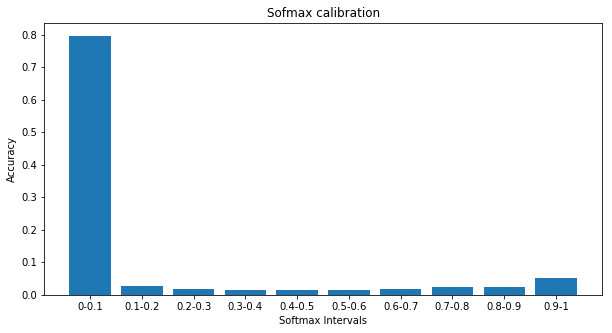

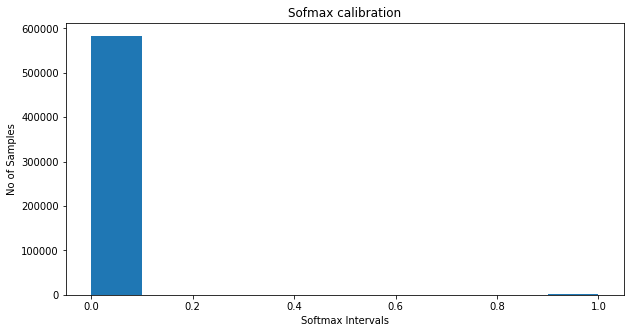

Predicted,Annelida,Brachyura,Candaciidae,Cavoliniidae,Centropagidae,Corycaeidae,Coscinodiscus,Decapoda,Doliolida,Eucalanidae,...,egg__other,eudoxie__Diphyidae,multiple__Copepoda,multiple__other,nauplii__Cirripedia,nauplii__Crustacea,tail__Appendicularia,tail__Chaetognatha,zoea__Decapoda,All
Actual,,,,,,,,,,,,,,,,,,,,,
Annelida,117,0,1,0,0,1,0,0,1,0,...,0,0,0,2,0,0,0,0,0,125
Bivalvia__Mollusca,1,0,0,0,0,0,0,0,0,0,...,100,0,0,0,0,0,0,0,0,221
Brachyura,88,24,4,1,0,43,0,0,0,0,...,9,0,0,1,0,0,0,0,11,262
Candaciidae,40,0,56,1,2,15,0,0,0,0,...,3,0,1,0,0,0,0,0,0,119
Cavoliniidae,43,2,0,57,1,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,114
Centropagidae,102,0,10,0,47,85,0,0,0,0,...,0,0,0,2,0,0,0,0,0,249
Corycaeidae,169,0,0,0,0,330,0,0,0,0,...,0,0,0,0,0,0,0,0,0,517
Coscinodiscus,52,0,0,0,0,0,13,0,0,0,...,542,0,0,0,0,0,0,0,0,688
Decapoda,166,0,1,0,0,7,0,13,0,0,...,6,0,0,1,0,0,2,2,2,200


In [42]:
plot_cm_calib(model, split[4], split[5], OH_enc, dict_classes, batch_size = 8)